In [2]:
import importlib
import sys

import numpy as np

# Force reload to avoid stale objects
if 'symbolic_bounds' in sys.modules:
    for mod in list(sys.modules.keys()):
        if mod.startswith('symbolic_bounds'):
            del sys.modules[mod]

from symbolic_bounds import DAG, DataGenerator, SCM, ProgramFactory
from symbolic_bounds.random_dag_generator import generate_random_partitioned_dag
import warnings
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

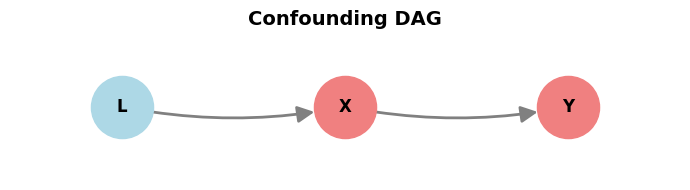

In [107]:
# 1. Generate a confounding DAG
dag = DAG()
X = dag.add_node('X', support={0, 1})
Y = dag.add_node('Y', support={0, 1})
L = dag.add_node('L', support={0, 1}, partition='L')
# L0 = dag.add_node('L0', support={0, 1}, partition='L')
dag.add_edge(X, Y)
dag.add_edge(L, X)

fig = dag.draw(figsize=(7, 2), title="Confounding DAG", with_labels=True)
plt.show()


In [108]:
dag.generate_all_response_types()
dag.print_response_type_table(X)
dag.print_response_type_table(Y)


Response types for X (parents: L):
=====

r_X^1:
L | X
-----
0 | 0
1 | 0

r_X^2:
L | X
-----
0 | 0
1 | 1

r_X^3:
L | X
-----
0 | 1
1 | 0

r_X^4:
L | X
-----
0 | 1
1 | 1


Response types for Y (parents: X):
=====

r_Y^1:
X | Y
-----
0 | 0
1 | 0

r_Y^2:
X | Y
-----
0 | 0
1 | 1

r_Y^3:
X | Y
-----
0 | 1
1 | 0

r_Y^4:
X | Y
-----
0 | 1
1 | 1



In [109]:
# 3. Generate Data
generator = DataGenerator(dag, seed=234)
joint = generator.computeObservedJoint() #Dict[FrozenSet[Tuple[Node, int]], float]
p11 = joint.get(frozenset({(X, 1), (Y, 1), (L, 1)}))
p10 = joint.get(frozenset({(X, 1), (Y, 0), (L, 1)}))
generator.print_true_distribution()
print(f'The known tian pearl bounds: [{p11:.4f}, {1-p10:.4f}] for P(Y=1 | do(X=1))')


TRUE RESPONSE TYPE DISTRIBUTION

Node: L
----------------------------------------
  P(R_L = 0) = 0.469110
  P(R_L = 1) = 0.530890
  Total: 1.000000

Node: X
----------------------------------------
  P(R_X = [(L=0)→0, (L=1)→0]) = 0.062698
  P(R_X = [(L=0)→0, (L=1)→1]) = 0.265685
  P(R_X = [(L=0)→1, (L=1)→0]) = 0.445713
  P(R_X = [(L=0)→1, (L=1)→1]) = 0.225903
  Total: 1.000000

Node: Y
----------------------------------------
  P(R_Y = [(X=0)→0, (X=1)→0]) = 0.005015
  P(R_Y = [(X=0)→0, (X=1)→1]) = 0.046779
  P(R_Y = [(X=0)→1, (X=1)→0]) = 0.388216
  P(R_Y = [(X=0)→1, (X=1)→1]) = 0.559990
  Total: 1.000000

The known tian pearl bounds: [0.1584, 0.8974] for P(Y=1 | do(X=1))


In [114]:
# 4. Create SCM
scm = SCM(dag, generator)

lp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))

lp.is_minimization = True
# lp.print_decision_variables()
# lp.print_objective()

lb = lp.solve(verbose=True).evaluate_objective(np.array([1]))

lp.is_minimization = False
ub = lp.solve(verbose=True).evaluate_objective(np.array([1]))
print(f"\nEstimated bounds for P(Y=1 | do(X=1)): [{lb:.6f}, {ub:.6f}]")

true_prob = generator.computeTrueIntervention(
    Y={Y}, 
    X={X}, 
    Y_values=(1,), 
    X_values=(1,)
)
print(f"True P(Y=1 | do(X=1)) = {true_prob:.6f}")

Building MPLP_Program:
  Variables: 16

Processing constraints (removing redundancies)...
Building MPLP_Program:
  Variables: 16

Processing constraints (removing redundancies)...

Estimated bounds for P(Y=1 | do(X=1)): [0.191170, 0.345218]
True P(Y=1 | do(X=1)) = 0.606769


In [115]:
# Create intervention data for autobound
# We need to create a DataFrame with intervention results
# Format: columns for intervention value, observed variables, and probabilities

import pandas as pd

# For a simple X->Y DAG with confounder U:
# We want to create intervention data for do(X=0) and do(X=1)
# Each row represents P(Y=y | do(X=x))

intervention_rows = []


x_val = 0
y_val = 0
# Compute the true intervention probability P(Y=y_val | do(X=x_val))
true_prob = generator.computeTrueIntervention(
    Y={Y}, 
    X={X}, 
    Y_values=(y_val,), 
    X_values=(x_val,)
)

intervention_rows.append({
    'X_do': x_val,      # Intervention column
    'Y': y_val,         # Observed variable
    'prob': true_prob   # Probability
})

df_intervention = pd.DataFrame(intervention_rows)
print("Intervention DataFrame:")
print(df_intervention)

# Now create the intervention_data dictionary
intervention_data = {
    'data': df_intervention,
    'intervention_node': 'X',
    'intervention_col': 'X_do',
    'observed_cols': ['Y']
}

# Call solve_with_autobound with intervention data
result = lp.solve_with_autobound(
    dag_structure="X -> Y, U->X, U->Y", 
    node_domains={'X': 2, 'Y': 2}, 
    unobserved_nodes="U",
    intervention_data=intervention_data,
    verbose=False,
    solver='glpk'
)

print(f"\nResults WITH intervention data:")
print(f"  Lower bound: {result['lower_bound']:.6f}")
print(f"  Upper bound: {result['upper_bound']:.6f}")
print(f"  Width: {result['width']:.6f}")

# Compare with true value
true_intervention_prob = generator.computeTrueIntervention(
    Y={Y}, 
    X={X}, 
    Y_values=(1,), 
    X_values=(1,)
)
print(f"\nTrue P(Y=1 | do(X=1)): {true_intervention_prob:.6f}")
print(f"True value in bounds? {result['lower_bound'] <= true_intervention_prob <= result['upper_bound']}")

Intervention DataFrame:
   X_do  Y      prob
0     0  0  0.051794

Results WITH intervention data:
  Lower bound: 0.349524
  Upper bound: 0.773482
  Width: 0.423958

True P(Y=1 | do(X=1)): 0.606769
True value in bounds? True


,parameter,lb,ub,w,true_prob
0,0.02,0.19117,0.345218,0.154048,0.051794
1,0.03,0.19117,0.345218,0.154048,0.051794
2,0.04,0.19117,0.345218,0.154048,0.051794
3,0.05,0.19117,0.345218,0.154048,0.051794
4,0.06,0.19117,0.345218,0.154048,0.051794
5,0.07,0.19117,0.345218,0.154048,0.051794
6,0.08,0.19117,0.345218,0.154048,0.051794
7,0.09,0.19117,0.345218,0.154048,0.051794
8,0.10,0.19117,0.345218,0.154048,0.051794
9,0.11,0.19117,0.345218,0.154048,0.051794


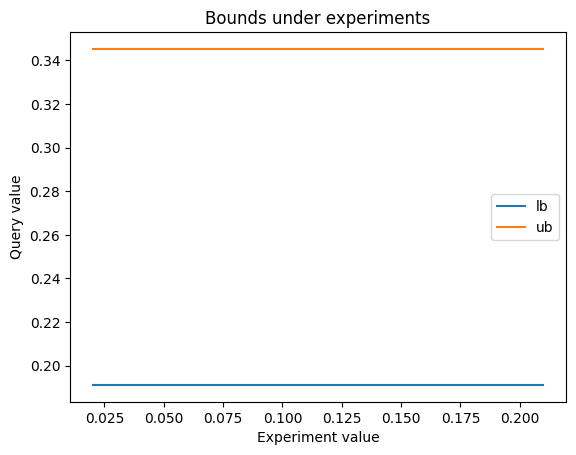

In [116]:
# Test with experimental constraints
lp_exp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,),
                                  V={Y}, Z={X}, V_values=(0,), Z_values=(0,))

lp_exp.is_minimization = True
result_lb = lp_exp.solve(verbose=False)
lp_exp.is_minimization = False
result_ub = lp_exp.solve(verbose=False)

import pandas as pd
df = pd.DataFrame(columns=['parameter', 'lb','ub', 'w','true_prob'])
for p in range(0, 101):  # Loop from 0 to 100 inclusive
    parameter = p / 100  # Convert to step size of 0.01
    lb = result_lb.evaluate_objective(np.array([parameter]))
    ub = result_ub.evaluate_objective(np.array([parameter]))
    if lb is None or ub is None:
        continue
    df = pd.concat([df, pd.DataFrame([{
        'parameter': parameter,
        'lb': lb,
        'ub': ub,
        'w': ub-lb,
        'true_prob': true_prob
    }])], ignore_index=True)

df.plot(x='parameter', xlabel='Experiment value', y=['lb', 'ub'], ylabel='Query value', title='Bounds under experiments')

df

# A More complex DAG

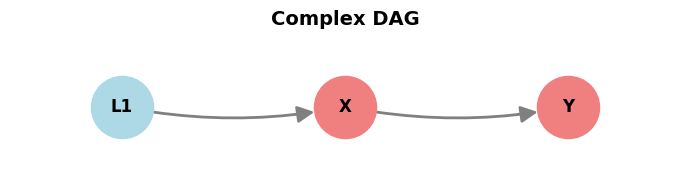

True P(Y=1 | do(X=1)) = 0.634191
The known tian pearl bounds: [0.0000, 1.0000] for P(Y=1 | do(X=1))


In [151]:
# 1. Generate a confounding DAG
dag = DAG()
X = dag.add_node('X', support={0, 1})
Y = dag.add_node('Y', support={0, 1})
# L0 = dag.add_node('L0', support={0, 1}, partition='L')
L1 = dag.add_node('L1', support={0, 1}, partition='L')
# dag.add_edge(L0, L1)
dag.add_edge(L1, X)
dag.add_edge(X, Y)

dag.generate_all_response_types()

fig = dag.draw(figsize=(7, 2), title="Complex DAG", with_labels=True)
plt.show()

# 3. Generate Data
generator = DataGenerator(dag, seed=234)
joint = generator.computeObservedJoint() #Dict[FrozenSet[Tuple[Node, int]], float]
# marginalize out L0 and L1
p11 = 0
p10 = 0
for l0 in [0, 1]:
    for l1 in [0, 1]:
        key11 = frozenset({(L0, l0), (L1, l1), (X, 1), (Y, 1)})
        key10 = frozenset({(L0, l0), (L1, l1), (X, 1), (Y, 0)})
        p11 += joint.get(key11, 0)
        p10 += joint.get(key10, 0)
# generator.print_true_distribution()
true_prob = generator.computeTrueIntervention(
    Y={Y}, 
    X={X}, 
    Y_values=(1,), 
    X_values=(1,)
)
print(f"True P(Y=1 | do(X=1)) = {true_prob:.6f}")
print(f'The known tian pearl bounds: [{p11:.4f}, {1-p10:.4f}] for P(Y=1 | do(X=1))')
# 4. Create SCM
scm = SCM(dag, generator)
lp_L1 = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))


In [178]:
lp_L.solve_with_highs()

{'status': 'HighsModelStatus.kInfeasible',
 'objective_value': None,
 'solution': None,
 'dual': None}

In [170]:
lp_L.rhs

array([0.0079788 , 0.14606932, 0.12389228, 0.19116971, 0.01397979,
       0.25593056, 0.10262536, 0.15835418])

In [169]:
lp_L1.rhs

array([0.05423884, 0.01352643, 0.01063249, 0.01843318, 0.43752901,
       0.10911377, 0.13042062, 0.22610567])

In [160]:
lp_L.constraint_matrix == lp_L1.constraint_matrix

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  Tru

In [176]:
dag_L = DAG()
X = dag_L.add_node('X', support={0, 1})
Y = dag_L.add_node('Y', support={0, 1})
# L0 = dag_L.add_node('L0', support={0, 1}, partition='L')
L1 = dag_L.add_node('L', support={0, 1}, partition='L')
# dag_L.add_edge(L0, L1)
dag_L.add_edge(L1, X)
dag_L.add_edge(X, Y)

dag_L

DAG(nodes=[Y, X, L], edges=[L->X, X->Y])

In [175]:
dag_L1 = DAG()
X = dag_L1.add_node('X', support={0, 1})
Y = dag_L1.add_node('Y', support={0, 1})
# L0 = dag_L1.add_node('L0', support={0, 1}, partition='L')
L1 = dag_L1.add_node('L1', support={0, 1}, partition='L')
# dag_L1.add_edge(L0, L1)
dag_L1.add_edge(L1, X)
dag_L1.add_edge(X, Y)

dag_L1

DAG(nodes=[L1, Y, X], edges=[L1->X, X->Y])

True P(Y=1 | do(X=1)) = 0.427410
The known tian pearl bounds: [0.0000, 1.0000] for P(Y=1 | do(X=1))
Solving LP with HiGHS:
  Variables: 16
  Constraints: 16
  Problem type: Minimization
  Slack tolerance: 0.01

Solving...


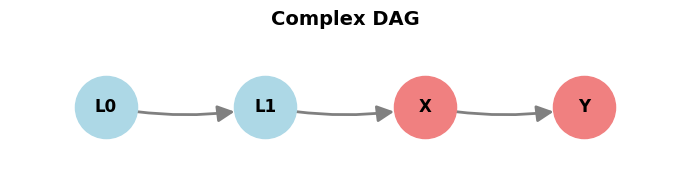

In [ ]:
# 1. Generate a confounding DAG
import highspy


dag = DAG()
X = dag.add_node('X', support={0, 1})
Y = dag.add_node('Y', support={0, 1})
L0 = dag.add_node('L0', support={0, 1}, partition='L')
L1 = dag.add_node('L1', support={0, 1}, partition='L')

dag.add_edge(X, Y)
dag.add_edge(L1, X)
dag.add_edge(L0, L1)
dag.generate_all_response_types()

fig = dag.draw(figsize=(7, 2), title="Complex DAG", with_labels=True)
# plt.show()

# 3. Generate Data
#seed works: 25463
#seed fails: 1
generator = DataGenerator(dag, seed=25463)
joint = generator.computeObservedJoint() #Dict[FrozenSet[Tuple[Node, int]], float]
# marginalize out L0 and L1
p11 = 0
p10 = 0
for l1 in [0, 1]:
    key11 = frozenset({(L1, l1), (X, 1), (Y, 1)})
    key10 = frozenset({(L1, l1), (X, 1), (Y, 0)})
    p11 += joint.get(key11, 0)
    p10 += joint.get(key10, 0)
# generator.print_true_distribution()
true_prob = generator.computeTrueIntervention(
    Y={Y}, 
    X={X}, 
    Y_values=(1,), 
    X_values=(1,)
)
print(f"True P(Y=1 | do(X=1)) = {true_prob:.6f}")
print(f'The known tian pearl bounds: [{p11:.4f}, {1-p10:.4f}] for P(Y=1 | do(X=1))')
# 4. Create SCM
scm = SCM(dag, generator)
lp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))

highs = lp.solve_with_highs(
    verbose=True,
    slack=0.01,
    give_highs_object=True
    # solver='ipopt'
)
highs.run()
status = highs.run()


status = highs.run()
if highs.getModelStatus() == highspy.HighsModelStatus.kInfeasible:
    iis = highspy.HighsIis()
    highs.getIis(iis)
print(iis.info)

dir(iis.info[0])

In [53]:
model_status = highs.getModelStatus()
print("Model status:", highs.modelStatusToString(model_status))
if model_status == highspy.HighsModelStatus.kInfeasible:
    iis = highspy.HighsIis()
    highs.getIis(iis)  # fills the object

    # Sanity check
    print("IIS valid:", iis.valid)

    # Indices of conflicting rows/cols
    rows = list(iis.row_index)
    cols = list(iis.col_index)

    print("Rows in IIS:", rows)
    print("Cols in IIS:", cols)

    # If your model has names, this is super helpful:
    print("\nConstraints in IIS:")
    for r in rows:
        try:
            name = highs.getRowName(r)
        except Exception:
            name = f"row_{r}"
        print(f"  row {r}: {name}")

    print("\nVariables in IIS:")
    for c in cols:
        try:
            name = highs.getColName(c)
        except Exception:
            name = f"col_{c}"
        print(f"  col {c}: {name}")

    # If you’re curious: which bound is causing trouble?
    print("\nRow bounds in IIS:")
    print(list(iis.row_bound))
    print("Col bounds in IIS:")
    print(list(iis.col_bound))

    # And statuses (in / may be in / not in IIS), if you want to inspect them:
    # print("Row status array:", list(iis.row_status_))
    # print("Col status array:", list(iis.col_status_))

Model status: Infeasible
IIS valid: True
Rows in IIS: [4, 6, 7, 8]
Cols in IIS: [0, 1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15]

Constraints in IIS:
  row 4: (<HighsStatus.kError: -1>, '')
  row 6: (<HighsStatus.kError: -1>, '')
  row 7: (<HighsStatus.kError: -1>, '')
  row 8: (<HighsStatus.kError: -1>, '')

Variables in IIS:
  col 0: (<HighsStatus.kError: -1>, '')
  col 1: (<HighsStatus.kError: -1>, '')
  col 4: (<HighsStatus.kError: -1>, '')
  col 5: (<HighsStatus.kError: -1>, '')
  col 6: (<HighsStatus.kError: -1>, '')
  col 7: (<HighsStatus.kError: -1>, '')
  col 8: (<HighsStatus.kError: -1>, '')
  col 9: (<HighsStatus.kError: -1>, '')
  col 12: (<HighsStatus.kError: -1>, '')
  col 13: (<HighsStatus.kError: -1>, '')
  col 14: (<HighsStatus.kError: -1>, '')
  col 15: (<HighsStatus.kError: -1>, '')

Row bounds in IIS:
[3, 3, 3, 2]
Col bounds in IIS:
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]


In [25]:
lp.print_full_lp()


                                   COMPLETE LINEAR PROGRAM

Problem type: Minimization
Variables: 16
Constraints: 16

DECISION VARIABLES q

Total variables: 16 (= ℵᴿ)
Each q[i] represents P(response type configuration i)

Complete enumeration:
--------------------------------------------------------------------------------

q[0]: r_X^1, r_Y^1
  Response type configuration:
    X:
      [L1=0] → 0
      [L1=1] → 0
    Y:
      [X=0] → 0
      [X=1] → 0

q[1]: r_X^1, r_Y^2
  Response type configuration:
    X:
      [L1=0] → 0
      [L1=1] → 0
    Y:
      [X=0] → 0
      [X=1] → 1

q[2]: r_X^1, r_Y^3
  Response type configuration:
    X:
      [L1=0] → 0
      [L1=1] → 0
    Y:
      [X=0] → 1
      [X=1] → 0

q[3]: r_X^1, r_Y^4
  Response type configuration:
    X:
      [L1=0] → 0
      [L1=1] → 0
    Y:
      [X=0] → 1
      [X=1] → 1

q[4]: r_X^2, r_Y^1
  Response type configuration:
    X:
      [L1=0] → 0
      [L1=1] → 1
    Y:
      [X=0] → 0
      [X=1] → 0

q[5]: r_X^2, r_Y^2